In [1]:
import pandas as pd
import numpy as np
# import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
import shap
import seaborn as sns
import yaml
import joblib

from scripts.check_overlaps import check_overlaps
from make_dataset import make_dataset_censored,  make_dataset_uncensored, repeat_masker, COSMIC_CGC_interactions, TF_binding_site_annotations, create_vep_input, read_vcf, long_range_interactions_results, create_vep_input, read_vcf, clean_and_preprocess

with open("configuration.yaml", "r") as yml_file:
    config = yaml.load(yml_file, yaml.Loader)

d:\Anaconda\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
d:\Anaconda\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=1

In [ ]:
df = pd.read_csv('data/dataset_uncensored.csv')
df = repeat_masker(df, 'train')
df = COSMIC_CGC_interactions(df, 'train')
df = TF_binding_site_annotations(df, 'train')
df = long_range_interactions_results(df, 'train')
df

In [ ]:
df_test = pd.read_csv('data/test_data_final.csv')
df_test = repeat_masker(df_test, 'test')
df_test = COSMIC_CGC_interactions(df_test, 'test')
df_test = TF_binding_site_annotations(df_test, 'test')
df_test = long_range_interactions_results(df_test, 'test')
df_test

Creating the input file for VEP<br>
This file is then given to Ensembl VEP <br>
We used the web version: https://grch37.ensembl.org/Homo_sapiens/Tools/VEP/<br>
Make sure you are using the Grch37 version

In [ ]:
df = create_vep_input(df, "data/VEP/vep_input.vcf")

In [ ]:
test_df_vcf = create_vep_input(df_test, "data/VEP/vep_input_test.vcf")

Reading VEP output<br>
The file generated by Ensembl VEP is downloaded (in .txt format) and used

In [ ]:
df_vep_output = read_vcf('data/VEP/vep_output.txt')
df_vep_output_test = read_vcf('data/VEP/vep_output_test.txt')

Clean and preprocess the data

In [ ]:
df_vep_output = clean_and_preprocess(df_vep_output)
df_vep_output_test = clean_and_preprocess(df_vep_output_test)

In [ ]:
data = df_vep_output.merge(df, left_on=['#Uploaded_variation'], right_on=['id'], how='right')
data_test = df_vep_output_test.merge(df_test, left_on=['#Uploaded_variation'], right_on=['id'], how='right')
data.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test

In [ ]:
data[data['Allele'].isna()]

In [ ]:
data = data.drop(list(set(data.columns) - set(data_test.columns)), axis = 1)
data_test = data_test.drop(list(set(data_test.columns) - set(data.columns)), axis = 1)

In [ ]:
# data_test[data_test['known_driver_gene_2kb_upstream'].isna()]
# df[df['id'].isin(data[data['Allele'].isna()]['id'])]
# df_test[df_test['id'].isin(data[data['Allele'].isna()]['id'])]
data[data['Allele'].isna()]['id']
# data['Allele']

In [ ]:
data[data['known_driver_gene_2kb_upstream'].isna()]

In [ ]:
data = pd.concat([data, data_test])

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data.reset_index(drop=True,inplace=True)
data.to_csv('data/final_dataset_combined.csv', index = False)
# data = pd.read_csv('data/final_dataset_combined.csv')

In [ ]:
# data.to_csv('data/final_dataset.csv', index = False)
# data_test.to_csv('data/final_dataset_test.csv', index = False)

In [ ]:
COLUMNS_TRAINING = set(COLUMNS_TRAINING) - set(data.columns[data.isna().any()].tolist())

# XGBoost

In [2]:
data = pd.read_csv('data/final_dataset_combined.csv')
data = data.sample(frac=1).reset_index(drop=True)

for col in data.columns[data.isna().any()].tolist():
    data[col].fillna(0, inplace=True)

data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']

data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])

In [3]:
XGB_PARAMS = {                                            # CODE SOURCE: containers_build\boostdm\config.py
        "objective": "binary:logistic",
        "reg_lambda": 1,
        "random_state": 42,
        "scale_pos_weight": 1,
        "subsample": 0.7,        # fraction of observations to be random samples for each tree
        "reg_alpha": 0,          # L1 regularization term on weight
        "max_delta_step": 0,    # positive value can help make the update step more conservative. generally not used
        "min_child_weight": 1,
        "learning_rate": 1e-03,
        "colsample_bylevel": 1.0,
        "gamma": 0,     # specifies the minimum loss reduction required to make a split. Makes the algorithm conservative
        "colsample_bytree": 1.0,        # fraction of columns to be random samples for each tree
        "booster": "gbtree",
        "max_depth": 4, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
        "silent": 1,
        "seed": 21,
        "eval_metric": 'logloss',
        "early_stopping_rounds": 2000
        # "reg_lambda": 1,  # explore this further

}

# 'ada_score', 'rf_score', 'CADD_PHRED', 'CADD_RAW', 'MODERATE', 'LOW', 'SWISSPROT', 'TREMBL', 'miRNA', 'sense_overlapping', 'misc_RNA'
# 'IG_D_gene', 'IG_J_gene', 'IG_C_gene', 'transcribed_unprocessed_pseudogene', 'non_stop_decay', '3prime_overlapping_ncRNA', 'pseudogene', 'transcribed_processed_pseudogene', 'rNA'
# 'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'start_lost', 'inframe_deletion', 'frameshift_variant' # not in positive set
# 'splice_acceptor_variant', 'coding_sequence_variant', 'splice_donor_region_variant', 'splice_donor_5th_base_variant' # not in negative set
# open_chromatin_region, 'snRNA', 'snoRNA' # not enough values
# 'STRAND', 'TF_binding_site_variant', 'TF_binding_site', 

COLUMNS_TRAINING = config['COLUMNS_TRAINING']

BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]

COLUMNS_SHAP = [f'my_shap_{x}' for x in COLUMNS_TRAINING]

for col in list(set(COLUMNS_TRAINING) - set(data.columns)):
    data[col] = 0

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

data[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data[COLUMNS_TRAINING])

# valset = data[-50:]
# data = data[:-50]
# valset['driver']

# Simple run

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                    random_state=104, 
                                                    test_size=0.25, 
                                                    shuffle=True)         # CODE SOURCE: containers_build\boostdm\training.py LIN 44
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=104) # 0.25 x 0.8 = 0.2

In [ ]:
params = XGB_PARAMS.copy()                                          
params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
params['base_score'] = y_train.mean()
params['silent'] = True
# params['n_jobs'] = 1
params['seed'] = 104
model = XGBClassifier(**params)

# train with xgboost
# learning_curve_dict = {}
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                    callbacks = [
                        xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False)
                    ],
                    verbose = 0)

params['n_estimators'] = model.best_iteration
model.set_params(**params)

In [4]:
filename = 'trained_model_combined.sav'
model = joblib.load(filename)

In [7]:
y_pred = model.predict(x_test)

In [8]:
score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % score)

Accuracy: 0.987


In [9]:
log_loss(y_pred, y_test)

0.4698427816086037

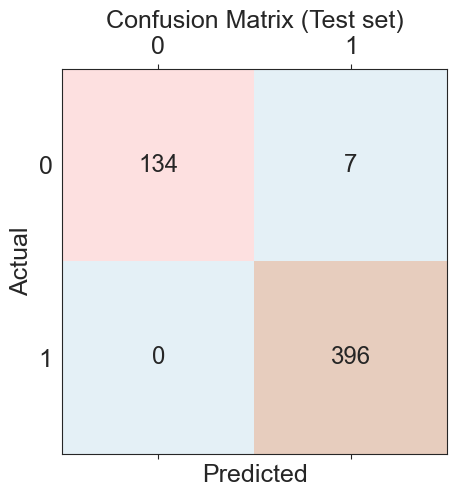

In [32]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Test set)', fontsize=18)
plt.show()

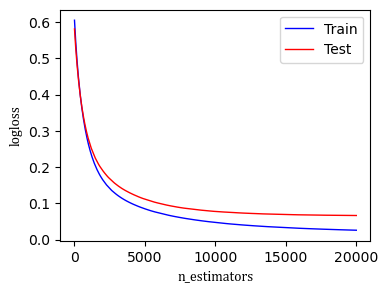

In [11]:
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train', color='blue', linewidth = '1')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test', color='red', linewidth = '1')
ax.legend()
plt.ylabel('logloss',{'fontname':'Cambria'})
plt.xlabel('n_estimators',{'fontname':'Cambria'})
# plt.title('XGBoost logloss', {'fontname':'Cambria'})
plt.show()

In [ ]:
from random import seed
from random import randrange
 
# zero rule algorithm for classification
def zero_rule_algorithm_classification(train, test):
 output_values = [row[-1] for row in train]
 prediction = max(set(output_values), key=output_values.count)
 predicted = [prediction for i in range(len(test))]
 return predicted

train = x_train
train['driver'] = y_train
test = x_test
test['driver'] = y_test
seed(1)
# train = [['0'], ['0'], ['0'], ['0'], ['1'], ['1']]
# test = [[None], [None], [None], [None]]
predictions = zero_rule_algorithm_classification(train, test)
print(predictions)

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
print('precision: ', precision_score(y_test, y_pred))
print('recall: ' , recall_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

precision:  0.9826302729528535
recall:  1.0
f1_score:  0.9912390488110138
roc_auc_score:  0.975177304964539


In [13]:
valsetpred = model.predict(x_val)
# print(valset['driver'])
# print(valsetpred)
score = accuracy_score(y_val, valsetpred)
print('Accuracy: %.3f' % score)

Accuracy: 0.988


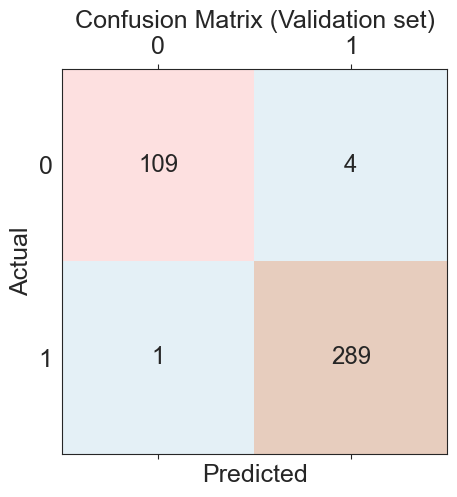

In [33]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_val, y_pred=valsetpred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Validation set)', fontsize=18)
plt.show()

In [15]:
valset = x_val.copy()
valset['driver'] = y_val
valset['predicted'] = valsetpred
valset['result'] = np.where(valset['driver'] == valset['predicted'], 'correct', 'wrong')
# wrongpred = valset[valset['driver'] != valset['predicted']]
# rightpred = valset[valset['driver'] == valset['predicted']]

In [34]:
valset['data_source']image.png

KeyError: 'data_source'

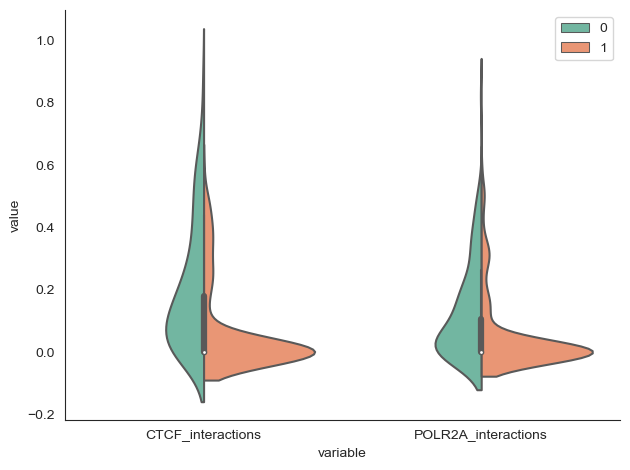

In [16]:
meltdf = valset[['CTCF_interactions', 'POLR2A_interactions', 'driver', 'result']].melt(id_vars=['driver'], value_vars=['CTCF_interactions', 'POLR2A_interactions'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='driver', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

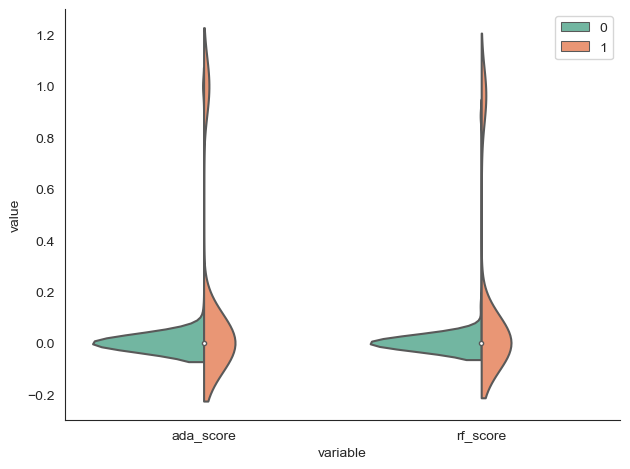

In [18]:
meltdf = valset[['ada_score', 'rf_score', 'driver', 'result']].melt(id_vars=['driver'], value_vars=['ada_score', 'rf_score'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='driver', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

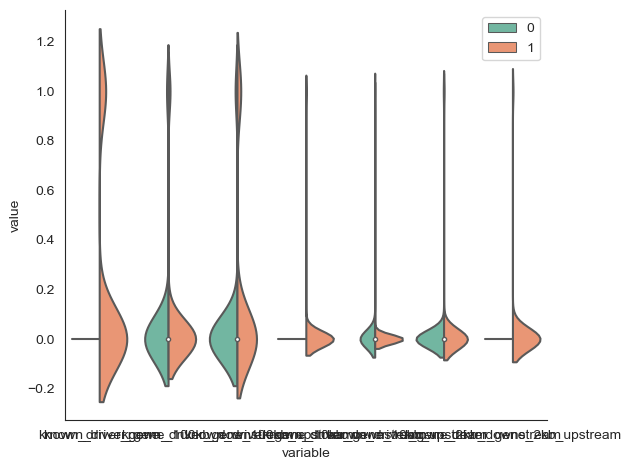

In [20]:
meltdf = valset[['known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream','known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream', 'driver']].melt(id_vars=['driver'], value_vars=['known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream','known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream',])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='driver', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

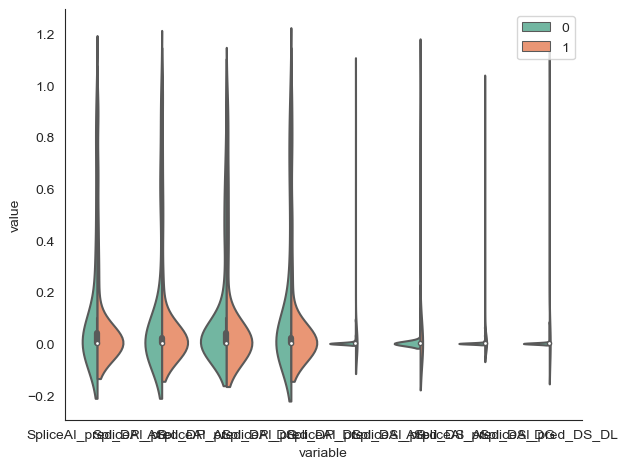

In [25]:
meltdf = valset[['SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', 'driver']].melt(id_vars=['driver'], value_vars=['SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='driver', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
meltdf = valset[['TF_loss_diff_add', 'TF_gain_diff_add', 'driver', 'result']].melt(id_vars=['driver'], value_vars=['TF_loss_diff_add', 'TF_gain_diff_add',])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='driver', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:

filename = 'trained_model_combined.sav'
joblib.dump(model, filename)
 
# some time later...
 
# load the model from disk
# model = joblib.load(filename)
# result = loaded_model.score(x_test, y_test)
# print(result)

SHAP Explainer

In [ ]:
# SHAP attribution
x_data = data[COLUMNS_TRAINING]
x_data = x_data.reindex(columns=COLUMNS_TRAINING)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
# shap_values = np.mean(shap_bootstrap, axis=0)


In [ ]:
for c in COLUMNS_SHAP:
    data[c] = np.nan
data.loc[data.index, COLUMNS_SHAP] = shap_values

In [ ]:
x_data.columns

In [ ]:
# x_data[['splice_acceptor_variant', 'splice_donor_variant', 'promoter', 'downstream_gene_variant', 'regulatory_region_variant']]#.describe()
# x_data.columns.get_loc('splice_acceptor_variant')
x_data.columns.get_loc('ENSP')
# x_data.columns.get_loc('LOEUF')
# data['driver'].value_counts()

In [ ]:
COLUMNS_TRAINING = config['COLUMNS_TRAINING']
COLUMNS_TRAINING

In [ ]:
#shap_values#[:,[60, 24, 38, 17, 23]]

In [ ]:
# shap.summary_plot(shap_values[:,2:5], x_data.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values[:,6:14], x_data.iloc[:, 6:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values[:,0:2], x_data.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
# shap.summary_plot(shap_values[:,44:48], x_data.iloc[:, 44:48], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values[:,53:60], x_data.iloc[:, 53:60], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values[:,48:53], x_data.iloc[:, 48:53], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values[:,73:77], x_data.iloc[:, 73:77], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values[:,5:6], x_data.iloc[:, 5:6], plot_size = 0.25)  # loeuf
# shap.summary_plot(shap_values[:,[60, 24, 38, 17, 23]], x_data.iloc[:, [60, 24, 38, 17, 23]], plot_size = 0.25) # the rest

In [ ]:
# data[data['missense_variant'].isna()]['id']


In [ ]:
shap.summary_plot(shap_values, x_data, max_display=40)

In [ ]:
shap.dependence_plot("CTCF_interactions", shap_values, x_data, interaction_index="CTCF_chains")

In [ ]:
# shap.plots.heatmap(shap_values)
shap_values_explaination = shap.Explanation(shap_values, feature_names=data[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination, max_display=12)

In [ ]:
x_data = data[COLUMNS_TRAINING]
explainer = shap.TreeExplainer(model) # grabbing the first model
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[101:200], x_data[101:200])

<Axes: >

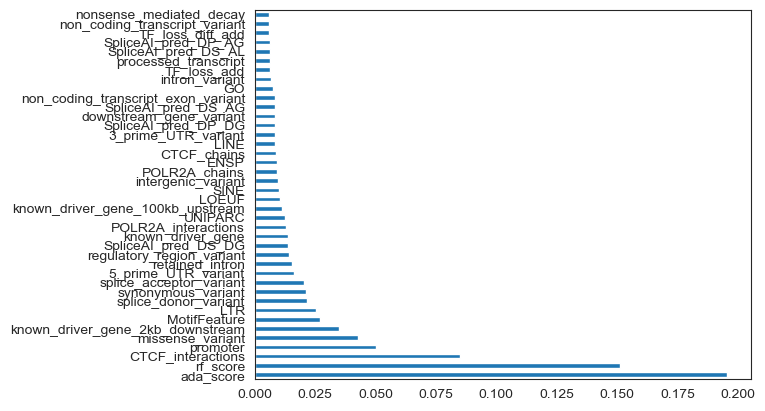

In [17]:
feat_importances = pd.Series(model.feature_importances_, index=data[COLUMNS_TRAINING].columns)
feat_importances.nlargest(40).plot(kind='barh')